In [1]:
import tensorflow as tf
from tensorflow import keras
from keras import Sequential
from keras.layers import Dense,Conv2D,MaxPooling2D,Flatten,BatchNormalization,Dropout
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
import cv2
import os
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
import numpy as np
import time

In [ ]:
!unzip Dataset.zip

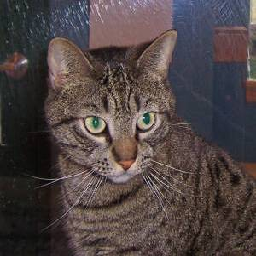

In [3]:
img = image.load_img('Dataset/train/cat/cat.1.jpg',target_size = (256,256))
img

In [4]:
datagen = ImageDataGenerator(rotation_range=30,
                             shear_range=0.2,
                             zoom_range=0.2,
                             horizontal_flip=True,
                             width_shift_range=0.2,
                             height_shift_range=0.2)

In [5]:
img = image.img_to_array(img)
input_batch = img.reshape(1,256,256,3)

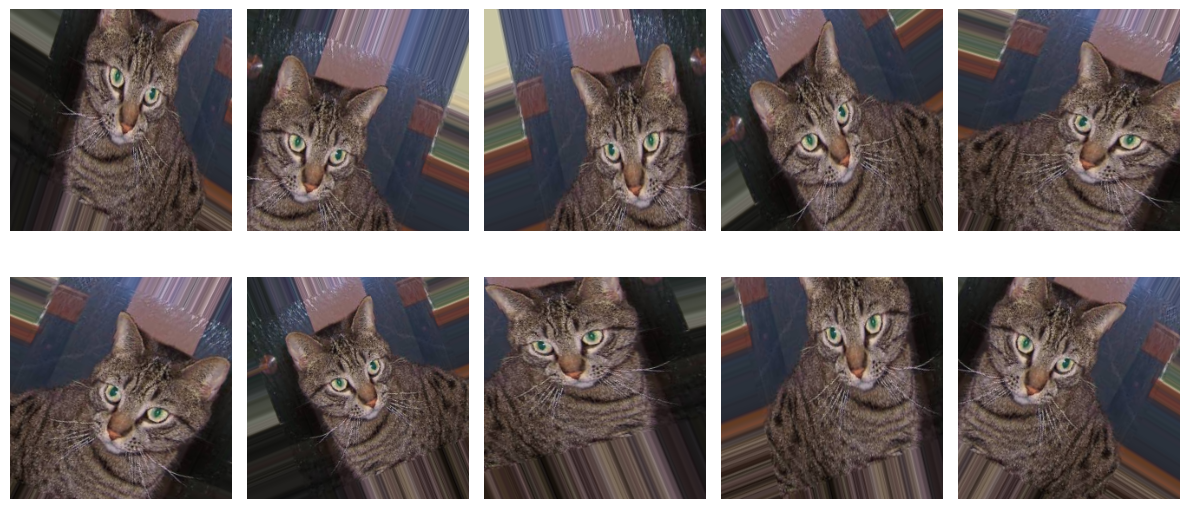

In [6]:
i = 0
fig, axes = plt.subplots(2, 5, figsize=(12, 6))

for output, ax in zip(datagen.flow(input_batch, batch_size=1), axes.flatten()):
    ax.imshow(output[0] / 255)
    ax.axis('off')
    i += 1
    if i == 10:
        break

plt.tight_layout()
plt.show()

In [7]:
batch_size = 10

train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True)

validation_datagen= ImageDataGenerator(rescale=1./255)
test_datagen= ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory('Dataset/train',
                                                    target_size=(256,256),
                                                    batch_size=batch_size,
                                                    class_mode='binary')

validation_generator = validation_datagen.flow_from_directory('Dataset/validation',
                                                    target_size=(256,256),
                                                    batch_size=batch_size,
                                                    class_mode='binary')



Found 120 images belonging to 2 classes.
Found 40 images belonging to 2 classes.


In [8]:
# create CNN model

model = Sequential()

model.add(Conv2D(32,kernel_size=(3,3),padding='valid',activation='relu',input_shape=(256,256,3)))
model.add(MaxPooling2D(pool_size=(2,2),strides=2,padding='valid'))

model.add(Conv2D(64,kernel_size=(3,3),padding='valid',activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2),strides=2,padding='valid'))

model.add(Conv2D(128,kernel_size=(3,3),padding='valid',activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2),strides=2,padding='valid'))

model.add(Flatten())

model.add(Dense(128,activation='relu'))
model.add(Dense(64,activation='relu'))
model.add(Dense(1,activation='sigmoid'))

In [9]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 127, 127, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 62, 62, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 30, 30, 128)       0

In [10]:
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

In [11]:
start_time = time.time()
history = model.fit(train_generator,
                    steps_per_epoch = 120 // batch_size,
                    epochs = 20,
                    validation_data=validation_generator,
                    validation_steps = 40 // batch_size)
end_time = time.time()
training_time = end_time - start_time
print("\n")
print("Training time = ", training_time)

Epoch 1/20
12/12 [==============================] - 9s 163ms/step - loss: 1.0202 - accuracy: 0.4750 - val_loss: 0.6925 - val_accuracy: 0.5000
Epoch 2/20
12/12 [==============================] - 2s 169ms/step - loss: 0.6978 - accuracy: 0.4917 - val_loss: 0.6924 - val_accuracy: 0.5000
Epoch 3/20
12/12 [==============================] - 2s 169ms/step - loss: 0.6889 - accuracy: 0.5500 - val_loss: 0.7076 - val_accuracy: 0.5000
Epoch 4/20
12/12 [==============================] - 2s 169ms/step - loss: 0.6913 - accuracy: 0.5167 - val_loss: 0.6715 - val_accuracy: 0.6500
Epoch 5/20
12/12 [==============================] - 2s 175ms/step - loss: 0.6705 - accuracy: 0.6250 - val_loss: 0.8514 - val_accuracy: 0.5000
Epoch 6/20
12/12 [==============================] - 3s 238ms/step - loss: 0.6660 - accuracy: 0.5917 - val_loss: 0.8159 - val_accuracy: 0.5750
Epoch 7/20
12/12 [==============================] - 2s 166ms/step - loss: 0.6685 - accuracy: 0.6250 - val_loss: 0.6974 - val_accuracy: 0.4500
Epoch 

1/1 [==============================] - 0s 384ms/step


array([[0.]], dtype=float32)

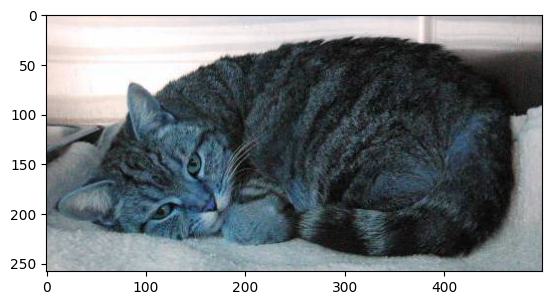

In [12]:
test_img1 = cv2.imread('/content/Dataset/test/cat/cat.76.jpg')
plt.imshow(test_img1)
test_img1 = cv2.resize(test_img1,(256,256))
test_input1 = test_img1.reshape((1,256,256,3))
model.predict(test_input1)

1/1 [==============================] - 0s 44ms/step


array([[1.]], dtype=float32)

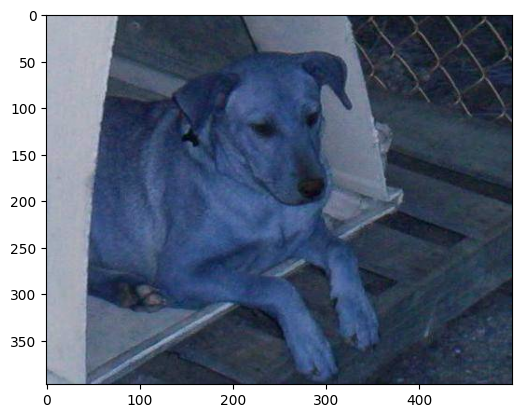

In [14]:
test_img2 = cv2.imread('/content/Dataset/test/dog/dog.100.jpg')
plt.imshow(test_img2)
test_img2 = cv2.resize(test_img2,(256,256))
test_input2 = test_img2.reshape((1,256,256,3))
model.predict(test_input2)

In [15]:
# Load test dataset
test_ds = keras.utils.image_dataset_from_directory(
    directory='Dataset/test',
    labels='inferred',
    label_mode='int',
    batch_size=32,
    image_size=(256, 256)
)

# Normalize
def process(image,label):
    image = tf.cast(image/255. ,tf.float32)
    return image,label

# Preprocess test data
test_ds = test_ds.map(process)

# Evaluate model on test data
test_loss, test_accuracy = model.evaluate(test_ds)
# Log testing accuracy
tf.summary.scalar('test_accuracy', test_accuracy, step=60)
print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_accuracy}')

Found 40 files belonging to 2 classes.
2/2 [==============================] - 2s 359ms/step - loss: 0.7376 - accuracy: 0.7000
Test Loss: 0.7376019358634949
Test Accuracy: 0.699999988079071


1/1 [==============================] - 0s 79ms/step


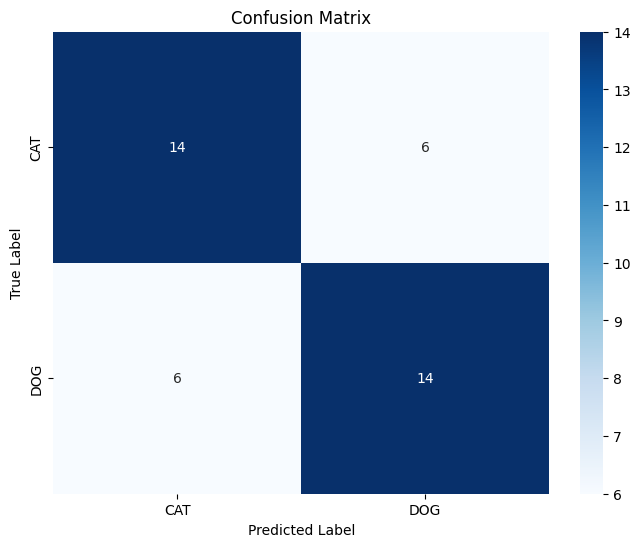

In [16]:
# Function to get predictions
def get_predictions(model, dataset):
    predictions = []
    labels = []
    for images, labels_batch in dataset:
        predictions_batch = model.predict(images)
        predictions.extend(np.round(predictions_batch).astype(int))
        labels.extend(labels_batch.numpy())
    return np.array(predictions).flatten(), np.array(labels)

# Get predictions for test data
test_predictions, test_labels = get_predictions(model, test_ds)

# Generate confusion matrix
cm = confusion_matrix(test_labels, test_predictions)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['CAT', 'DOG'], yticklabels=['CAT', 'DOG'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()